In [1]:
import os,sys,time
import tensorflow as tf
import numpy as np
import librosa
sys.path.insert(0, './scripts')
sys.path.insert(0, './models')
import e2e_model as nn_model_foreval

def cmvn_slide(feat,winlen=300,cmvn=False): #feat : (length, dim) 2d matrix
# function for Cepstral Mean Variance Nomalization

    maxlen = np.shape(feat)[0]
    new_feat = np.empty_like(feat)
    cur = 1
    leftwin = 0
    rightwin = winlen/2
    
    # middle
    for cur in range(maxlen):
        cur_slide = feat[cur-leftwin:cur+rightwin,:] 
        #cur_slide = feat[cur-winlen/2:cur+winlen/2,:]
        mean =np.mean(cur_slide,axis=0)
        std = np.std(cur_slide,axis=0)
        if cmvn == 'mv':
            new_feat[cur,:] = (feat[cur,:]-mean)/std # for cmvn        
        elif cmvn =='m':
            new_feat[cur,:] = (feat[cur,:]-mean) # for cmn
        if leftwin<winlen/2:
            leftwin+=1
        elif maxlen-cur < winlen/2:
            rightwin-=1    
    return new_feat


def feat_extract(filelist,feat_type,n_fft_length=512,hop=160,vad=True,cmvn=False,exclude_short=500):
# function for feature extracting
        
    feat = []
    utt_shape = []
    new_utt_label =[]
    for index,wavname in enumerate(filelist):
        #read audio input
        y, sr = librosa.core.load(wavname,sr=16000,mono=True,dtype='float')

        #extract feature
        if feat_type =='melspec':
            Y = librosa.feature.melspectrogram(y,sr,n_fft=n_fft_length,hop_length=hop,n_mels=40,fmin=133,fmax=6955)
        elif feat_type =='mfcc':
            Y = librosa.feature.mfcc(y,sr,n_fft=n_fft_length,hop_length=hop,n_mfcc=40,fmin=133,fmax=6955)
        elif feat_type =='spec':
            Y = np.abs( librosa.core.stft(y,n_fft=n_fft_length,hop_length=hop,win_length=400) )
        elif feat_type =='logspec':
            Y = np.log( np.abs( librosa.core.stft(y,n_fft=n_fft_length,hop_length=hop,win_length=400) ) )
        elif feat_type =='logmel':
            Y = np.log( librosa.feature.melspectrogram(y,sr,n_fft=n_fft_length,hop_length=hop,n_mels=40,fmin=133,fmax=6955) )

        Y = Y.transpose()
        
        
        # Simple VAD based on the energy
        if vad:
            E = librosa.feature.rmse(y, frame_length=n_fft_length,hop_length=hop,)
            threshold= np.mean(E)/2 * 1.04
            vad_segments = np.nonzero(E>threshold)
            if vad_segments[1].size!=0:
                Y = Y[vad_segments[1],:]

                
        #exclude short utterance under "exclude_short" value
        if exclude_short == 0 or (Y.shape[0] > exclude_short):
            if cmvn:
                Y = cmvn_slide(Y,300,cmvn)
            feat.append(Y)
            utt_shape.append(np.array(Y.shape))
#             new_utt_label.append(utt_label[index])
            sys.stdout.write('%s\r' % index)
            sys.stdout.flush()
            
        if index ==0:
            break

        
    tffilename = feat_type+'_fft'+str(n_fft_length)+'_hop'+str(hop)
    if vad:
        tffilename += '_vad'
    if cmvn=='m':
        tffilename += '_cmn'
    elif cmvn =='mv':
        tffilename += '_cmvn'
    if exclude_short >0:
        tffilename += '_exshort'+str(exclude_short)

    return feat, new_utt_label, utt_shape, tffilename #feat : (length, dim) 2d matrix
    
    

In [2]:
# Feature extraction configuration
FEAT_TYPE = 'logmel'
N_FFT = 400
HOP = 160
VAD = True
CMVN = 'mv'
EXCLUDE_SHORT=0
IS_BATCHNORM = False
IS_TRAINING = False
INPUT_DIM = 40

# extracting mfcc for input wavfile
FILENAME = ['/data/sls/qcri/asr/data/vardial/vardial2017/test.vardial2017/wav/EGY/04d3ad10aceb69fcfb3a55d102ba7cff_M_0004_116.66_129.74.wav']
start_time = time.time()

feat, utt_label, utt_shape, tffilename = feat_extract(FILENAME,FEAT_TYPE,N_FFT,HOP,VAD,CMVN,EXCLUDE_SHORT)

elapsed_time = time.time() - start_time
print format(elapsed_time) + ' seconds'
print np.shape(feat)

0.224723815918 seconds
(1, 914, 40)


In [3]:
# Variable Initialization    

softmax_num = 5
x = tf.placeholder(tf.float32, [None,None,40])
y = tf.placeholder(tf.int32, [None])
s = tf.placeholder(tf.int32, [None,2])

emnet_validation = nn_model_foreval.nn(x,y,y,s,softmax_num,IS_TRAINING,INPUT_DIM,IS_BATCHNORM);
sess = tf.InteractiveSession()
saver = tf.train.Saver()
tf.initialize_all_variables().run()

### Loading neural network 
saver.restore(sess,'./data/pretrained_model/model1284000.ckpt-1284000')

/data/sls/u/swshon/tools/pytf/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor("transpose:0", shape=(?, ?, ?), dtype=float32)
Tensor("transpose_1:0", shape=(?, ?, ?), dtype=float32)
Tensor("transpose_2:0", shape=(?, ?, ?), dtype=float32)
Tensor("transpose_3:0", shape=(?, ?, ?), dtype=float32)
Tensor("Mul:0", shape=(?, ?, 500), dtype=float32)
(?, 3000)
(?, 1500)
(?, 600)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from ./data/pretrained_model/model1284000.ckpt-1284000


In [4]:
start_time = time.time()

likelihood= emnet_validation.o1.eval({x:feat, s:utt_shape})

elapsed_time = time.time() - start_time
print format(elapsed_time) + ' seconds'

2.9759850502 seconds


The Input wav file /data/sls/qcri/asr/data/vardial/vardial2017/test.vardial2017/wav/EGY/04d3ad10aceb69fcfb3a55d102ba7cff_M_0004_116.66_129.74.wav is
 [Egytion]


Text(0.5,1,u'Dialect identification offline test result')

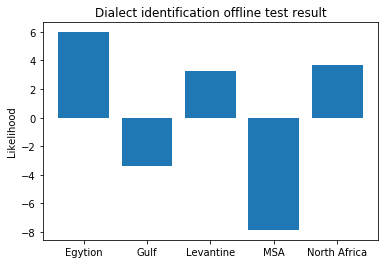

In [5]:
# Print out the results in barplot
# print likelihood
dialect_index = np.argmax(likelihood)

print 'The Input wav file '+FILENAME[0]+' is'
if dialect_index == 0:
    print ' [Egytion]'
elif dialect_index == 1:
    print ' [Gulf]'
elif dialect_index == 2:
    print ' [Levantine]'
elif dialect_index == 3:
    print ' [Modern Standard Arabic]'
elif dialect_index == 4:
    print ' [North African]'
    

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

x = np.arange(5)
dialects = ['Egytion','Gulf','Levantine','MSA','North Africa']
plt.bar(x,likelihood[0],align='center')
plt.xticks(x,dialects)
plt.ylabel('Likelihood')
plt.title('Dialect identification offline test result')